# Notebook for testing flux limits

### Setup

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
CDFS = pd.DataFrame(data)
CDFS['source'] = 'CDFS'

data = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
COSMOS = pd.DataFrame(data)
COSMOS['source'] = 'COSMOS'

data = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN.csv', usecols=['Use', 'zpk', 'LIR', 'F24'])
UDS = pd.DataFrame(data)
UDS['source'] = 'UDS'

df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
df = df[df['LIR'] > 0]
df = df[df['Use'] == 1]

cdfs_percentiles = [25, 25, 25, 25, 
                    30, 30, 30, 30, 
                    40, 40, 60, 45, 
                    30] # percentiles for each CDFS redshift bin

cosmos_percentiles = [20, 20, 20, 15, 
                      15, 15, 15, 10, 
                      15, 15, 40, 30, 
                      30] # percentiles for each COSMOS redshift bin

uds_percentiles = [25, 25, 15, 15, 
                   15, 15, 15, 15, 
                   15, 20, 35, 30, 
                   30] # percentiles for each UDS redshift bin

z_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
        (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
        (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 5.0),
        (5.0, 6.0)] # redshift bins

names = ['CDFS', 'COSMOS', 'UDS']
percentiles = [cdfs_percentiles, cosmos_percentiles, uds_percentiles]

# names = ['CDFS']
# percentiles = [cdfs_percentiles]

### Bolometric Luminosity vs Redshift

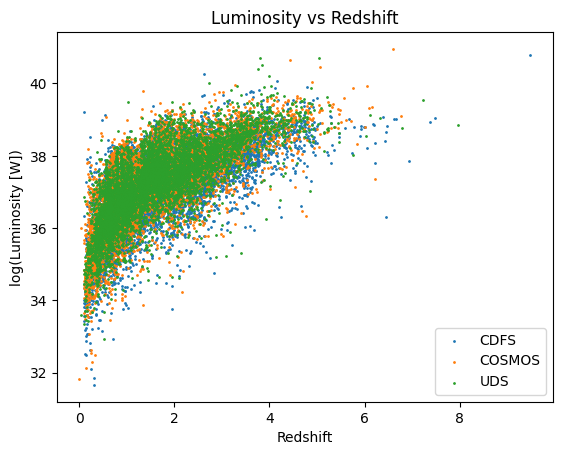

In [208]:
z = df['zpk'].values # redshift

lum = df['LIR'].copy().values # solar luminosity
lum *= 3.828 * 10 ** 26 # solar luminosity -> Watts

for name in names:
    mask_name = df['source'] == name
    plt.scatter(z[mask_name], np.log10(lum[mask_name]), s=1, label=name)
plt.title('Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(Luminosity [W])')
plt.legend()
plt.show()

### Bolometric Flux

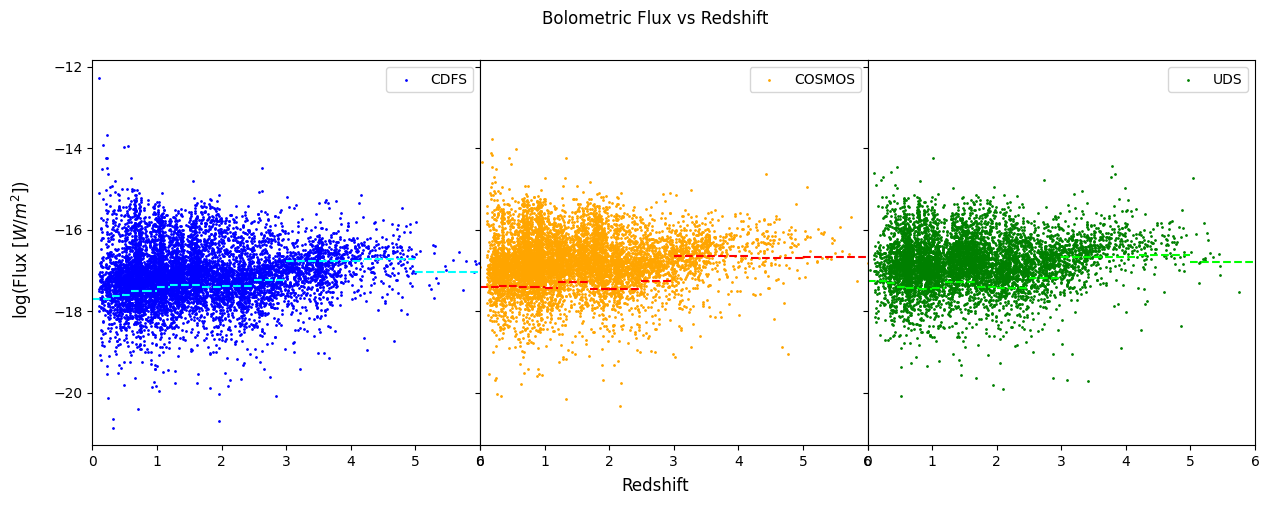

In [209]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to(u.m).value # m

F_bol = lum / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
colours = ['cyan', 'red', 'lime']
colours2 = ['blue', 'orange', 'green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

for name, pertile, c1, c2, ax in zip(names, percentiles, colours, colours2, axes.flatten()):
    mask_name = df['source'] == name
    ax.scatter(z[mask_name], np.log10(F_bol[mask_name]), s=1, label=name, c=c2)
    ax.legend()
    for (z_start, z_end), per in zip(z_bins, pertile):
        mask_z = (z >= z_start) & (z < z_end)
        p = np.percentile(F_bol[mask_name & mask_z], per) # 80% of the data is above this value
        ax.hlines(np.log10(p), color=c1, linestyle='--', label='Flux limit', xmin=z_start, xmax=z_end)
        F_lims.append(p)
        ax.set_xlim(0, 6)

fig.suptitle('Bolometric Flux vs Redshift')
fig.supylabel('log(Flux [$W/m^2$])', x=0.07)
fig.supxlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.show()

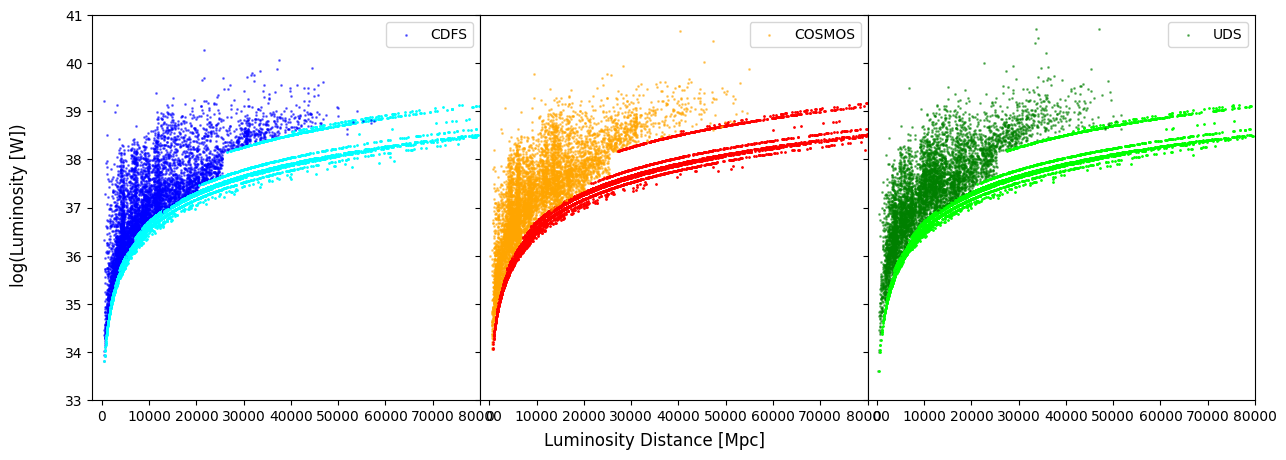

In [210]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).value # Mpc
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

for name, c1, c2, ax in zip(names, colours, colours2, axes.flatten()):
    for i, ((z_start, z_end), F_lim) in enumerate(zip(z_bins, F_lims)): 
        mask_z = (z >= z_start) & (z < z_end)
        mask_name = df['source'] == name
        mask_flux = F_bol > F_lim
        ax.scatter(d_L[mask_name & mask_z & mask_flux], np.log10(lum[mask_name & mask_z & mask_flux]), s=1, alpha=0.5, color=c2, label=name if i == 0 else '')
        ax.legend()
        
        dmax = np.sqrt(lum[mask_name & mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
        dmax *= 3.241 * 10 **-23
        ax.scatter(dmax, np.log10(lum[mask_name & mask_z & mask_flux]), s=1, color=c1)
        ax.set_xlim(-2000, 80000)
        ax.set_ylim(33, 41)
        
fig.supylabel('log(Luminosity [W])', x=0.07)
fig.supxlabel('Luminosity Distance [Mpc]')
plt.subplots_adjust(wspace=0)
plt.show()

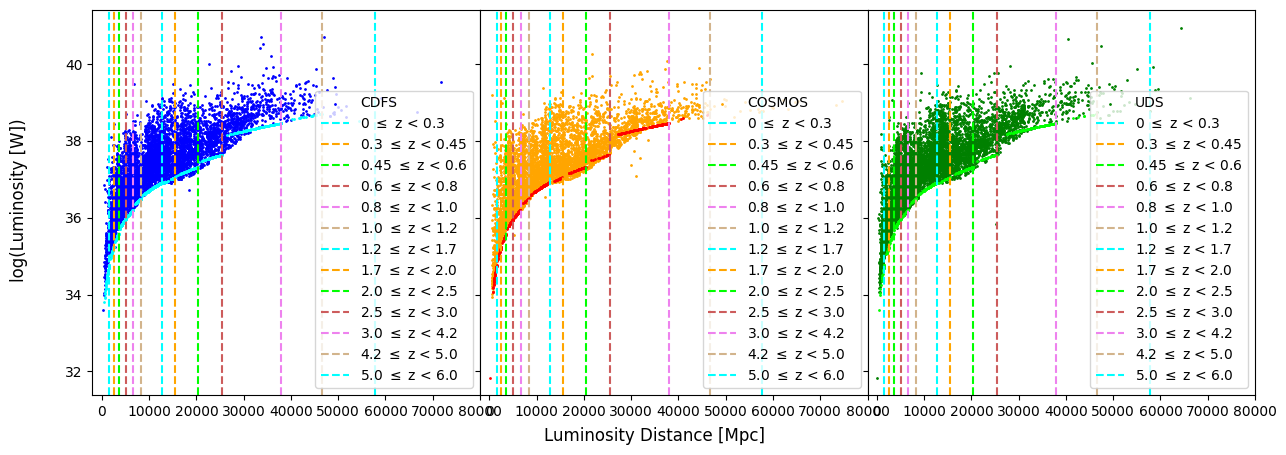

In [211]:
Flim = 0.003 # mJy
mask_f = df['F24'] > Flim

lum_new = df['LIR'].copy().values # solar luminosity
lum_new *= 3.828 * 10 ** 26 # solar luminosity -> Watts

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

# colours3 = ['skyblue', 'brown', 'olivedrab']
colours3 = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']

for name, c1, c2, ax in zip(names, colours, colours2, axes.flatten()):
    ax.scatter(d_L[mask_name & mask_f], np.log10(lum_new[mask_name & mask_f]), s=1, label=name, color=c2)
    for i, ((z_start, z_end), F_lim, c3) in enumerate(zip(z_bins, F_lims, colours3)):
        mask_z = (z >= z_start) & (z < z_end)
        mask_name = df['source'] == name
        mask_flux = F_bol > F_lim
        
        dmaxs = np.sqrt(lum[mask_name & mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
        dmaxs *= 3.241 * 10 **-23
        
        # rb_min = cosmo.luminosity_distance(z_start).value
        rb_max = cosmo.luminosity_distance(z_end).value
        mask_d = dmaxs <= rb_max
        # mask_d = (dmaxs >= rb_min) & (dmaxs <= rb_max)
        
        ax.scatter(dmaxs[mask_d], np.log10(lum[mask_name & mask_z & mask_flux][mask_d]), s=1, color=c1)
        ax.axvline(cosmo.luminosity_distance(z_end).value, color=c3, linestyle='--', label=f'{z_start} $\leq$ z < {z_end}')
        ax.set_xlim(-2000, 80000)
        ax.legend()
        # plt.text(cosmo.luminosity_distance(z_end).value+1e3, max(np.log10(lum)), f'z = {z_end}', color=c)
fig.supylabel('log(Luminosity [W])', x=0.07)
fig.supxlabel('Luminosity Distance [Mpc]')
plt.subplots_adjust(wspace=0)
plt.show()

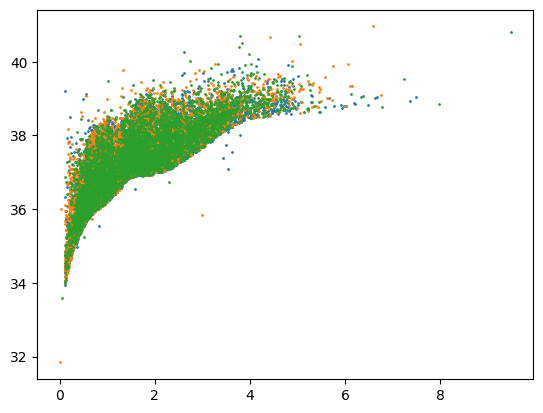

In [222]:
for name in names:
    mask_name = df['source'] == name
    mask_f = df['F24'] > Flim
    plt.scatter(z[mask_name & mask_f], np.log10(lum_new[mask_name & mask_f]), s=1, label=name)

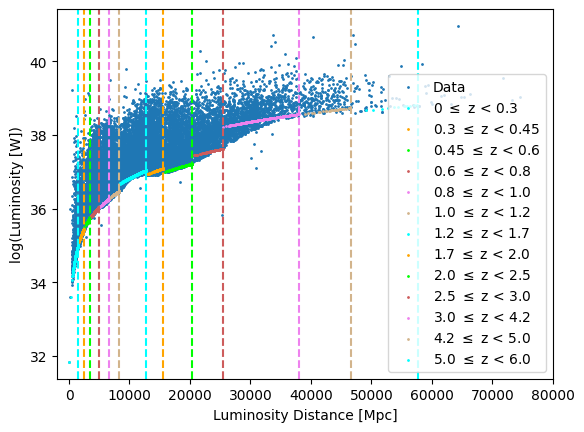

In [217]:
all_percentiles = [25, 25, 25, 20,
               20, 20, 25, 20,
               20, 25, 50, 35,
               30] # percentiles for each redshift bin all ZFOURGE

all_F_lims = []
for (z_start, z_end), per in zip(z_bins, all_percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    p = np.percentile(F_bol[mask_z], per) # 80% of the data is above this value
    all_F_lims.append(p)

Flim = 0.003 # mJy
mask_f = df['F24'] > Flim

plt.scatter(d_L[mask_f], np.log10(lum[mask_f]), s=1, label='Data')

colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']

for (z_start, z_end), F_lim, c in zip(z_bins, all_F_lims, colours):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    
    dmaxs = np.sqrt(lum_new[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmaxs *= 3.241 * 10 **-23
    
    rb_max = cosmo.luminosity_distance(z_end).value
    mask_d = dmaxs <= rb_max
    
    plt.scatter(dmaxs[mask_d], np.log10(lum_new[mask_z & mask_flux][mask_d]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
    plt.axvline(cosmo.luminosity_distance(z_end).value, color=c, linestyle='--')
plt.ylabel('log(Luminosity [W])')
plt.xlabel('Luminosity Distance [Mpc]')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()